Эмоциональная детализация - это способность индивида различать специфику своих эмоций. Человек с высокой эмоциональной детализацией способен различать свои эмоции, которые все находятся в пределах одного и того же уровня валентности (Valence) и возбуждения (Arousal), обозначая свои переживания дискретными эмоциональными словами.
Эмоции можно отобразить на диаграмме, моделирующей диапазон возбуждения (от высокого до низкого) и валентности (от удовольствия до неудовольствия), которое испытывается во время определенной эмоции. Например, в правом верхнем углу находятся эмоции с высоким возбуждением и высокой валентностью, включая возбужденное, удивленное, восхищенное, счастливое и довольное. Все эти эмоции являются примерами положительных эмоций, которые вызывают сильное возбуждение. В противоположном углу находится секция низкой валентности и низкого возбуждения, содержащая в качестве некоторых примеров несчастных, подавленных, скучающих и усталых.

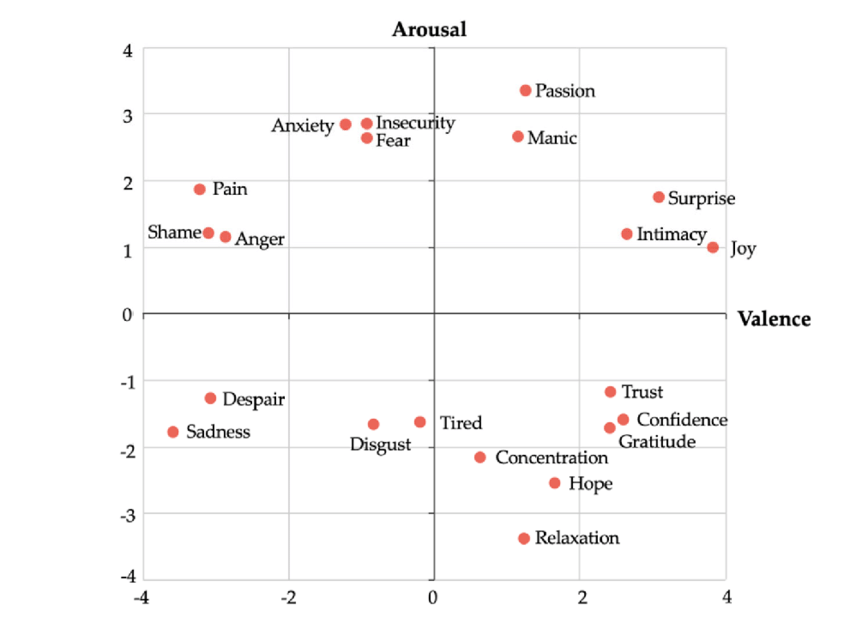

In [ ]:
!pip install keras_vggface
!pip install keras_applications
!pip install livelossplot

In [15]:
import os
import time
import random
from math import pi, cos, sin, sqrt
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from livelossplot.tf_keras import PlotLossesCallback
from pathlib import Path
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
BASE_DIR = Path('/content')
PATH_MYDRIVE = Path('/content/drive/MyDrive/Skillbox/CNN_Final_Project/')
PATH_TRAIN = BASE_DIR / 'train'
PATH_TEST = BASE_DIR / 'test_kaggle'
PATH_PROCESSED = BASE_DIR / 'processed' # обрезанные по bounding-box изображения
os.chdir(BASE_DIR)

In [5]:
from google_drive_downloader import GoogleDriveDownloader as gdd

# train.zip (предобработанные изображения по яркости/контрасту. см. Часть 1)
gdd.download_file_from_google_drive(file_id='1CRScUZYvmoKr6hnb82szdgRB7X-mEQjl',
                                    dest_path=BASE_DIR / 'train.zip', unzip=True)

#test_kaggle.zip (download from Kaggle)
gdd.download_file_from_google_drive(file_id='1bGHeWeWYXj5biL9s-qTc9gyv91WNAbWE',
                                   dest_path=BASE_DIR / 'test_kaggle.zip', unzip=True)

#train.csv (download from Kaggle)
df = pd.read_csv(PATH_MYDRIVE / 'train.csv', sep=',', index_col=0)

# датасеты. см. Часть 1
df_train = pd.read_csv(PATH_MYDRIVE / 'df_train.csv', sep=',', index_col='index')
df_test = pd.read_csv(PATH_MYDRIVE / 'df_test.csv', sep=',', index_col='index')

Unzipping...Done.
Unzipping...Done.


Определим численные соотношения между эмоциями по Valence-Arousal

In [8]:
# fisrt number - valence, second - arousal
VA_mapping = {
    'anger':    [ -3,    1  ],   #гнев
    'contempt': [ -3.5, -0.5],   #презрение
    'disgust':  [ -1,   -1.8],   #отвращение
    'fear':     [ -1,    2.8],   #страх
    'happy':    [  4,    1  ],   #радость
    'neutral':  [  0,    0  ],   #безразличие
    'sad':      [ -3.5, -1.8],   #грусть
    'surprise': [  3,    2  ],   #удивление
    'uncertain':[  0,   -2  ]    #неопределенность
}

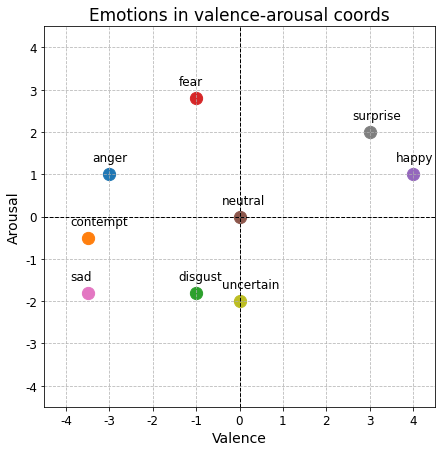

In [ ]:
def emotion_plot(VA_mapping):
    plt.figure(figsize=(7,7))
    max_value = 0
    for category, (v, a) in VA_mapping.items():
        plt.scatter(v, a, label=category, s=150)
        plt.text(v-0.4, a+0.3, category, size=12)
        max_value = max([max_value, np.abs(v), np.abs(a)])
    xmin, xmax = plt.xlim(-max_value-0.5, max_value + 0.5)
    ymin, ymax = plt.ylim(-max_value-0.5, max_value + 0.5)
    plt.vlines(0, ymin, ymax, linestyle='dashed', lw=1)
    plt.hlines(0, xmin, xmax, linestyle='dashed', lw=1)
    ticks = range(-int(max_value + 0.5), int(max_value + 0.5) + 1)
    plt.xticks(ticks, ticks, size=12)
    plt.yticks(ticks, ticks, size=12)
    plt.grid(alpha=0.9, linestyle='--')
    plt.xlabel('Valence', size=14)
    plt.ylabel('Arousal', size=14)
    plt.title('Emotions in valence-arousal coords', size=17)
    plt.show()

emotion_plot(VA_mapping)

Для обучения модели в valence-arousal разложением эмоций необходима разметка фотографий по этим параметрам. В предоставленном дата-сете такой разметки нет. Поэтому воспринимаем данное задание как явно учебное. В связи с этим сгенерируем случайным образом значения пар Valence/Arousal в приблизительно допустимых диапазонах для каждого изображения. Сконструируем соответствующую модель нейронной сети, обучим её на полученных значениях.

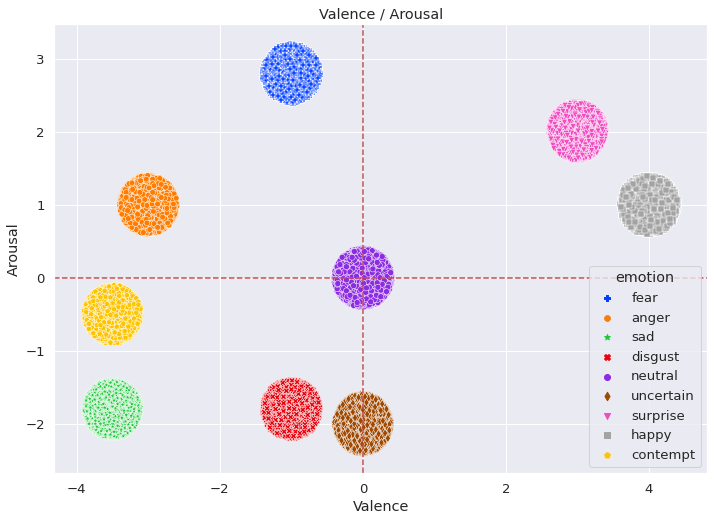

In [ ]:
def circle (radius):
  r = np.random.uniform(low=0, high=radius**2)
  theta = np.random.uniform(low=0, high=2*np.pi)
  x = np.sqrt(r) * np.cos(theta)
  y = np.sqrt(r) * np.sin(theta)
  return (x,y)

valence = []
arousal = []

for emotion in df_train['emotion']:
    valence_val,arousal_val = circle(0.4)
    valence_val += VA_mapping.get(emotion)[0]
    arousal_val += VA_mapping.get(emotion)[1]
    valence.append(np.round(valence_val, 2))
    arousal.append(np.round(arousal_val, 2))

df_train['Valence'] = valence
df_train['Arousal'] = arousal

sns.set(rc={'figure.figsize': (11.7, 8.27)}, font_scale=1.2, style='darkgrid')

markers = {'anger': '8', 
           'contempt': 'p', 
           'disgust': 'X', 
           'fear': 'P', 
           'happy':'s', 
           'neutral':'o', 
           'sad':'*', 
           'surprise':'v', 
           'uncertain':'d'}

sns.scatterplot(x='Valence', y='Arousal', data=df_train,
                hue='emotion', palette='bright', style='emotion', markers=markers)
plt.title('Valence / Arousal')
plt.axvline(x=0, color="r", linestyle="--")
plt.axhline(y=0, color="r", linestyle="--")
plt.show()

df_train.to_csv(PATH_MYDRIVE / 'df_train.csv', sep=',', index_label='index')

In [ ]:
df_train

,weight,width,heigth,emotion,filename,notsquare,lvalueld,face_count,image_path,Valence,Arousal
index,,,,,,,,,,,
1,7878,379,379,fear,2803.jpg,0,11.865651,1,fear/2803.jpg,-1.18,2.59
2,3039,192,192,fear,4569.jpg,0,12.455973,1,fear/4569.jpg,-0.90,2.49
4,15547,616,616,fear,3409.jpg,0,13.185115,1,fear/3409.jpg,-0.83,3.14
5,10635,455,455,anger,6217.jpg,0,13.625118,1,anger/6217.jpg,-2.96,1.22
6,6818,436,436,fear,1478.jpg,0,14.116141,1,fear/1478.jpg,-1.05,3.12
...,...,...,...,...,...,...,...,...,...,...,...
49019,175140,1514,1514,neutral,548.jpg,0,225.409093,1,neutral/548.jpg,0.20,0.21
49020,71626,951,951,fear,1036.jpg,0,226.492290,1,fear/1036.jpg,-1.09,3.05
49021,11845,466,466,surprise,5633.jpg,0,230.773186,1,surprise/5633.jpg,3.20,1.74


In [9]:
# разделим датасет на обучающую и валидационную выборку
def stratified_split_ds(data, validation_split=0.2, seed=42):
    """Stratified split of dataframe base on column 'emotion'."""
    rnd_seed = np.random.RandomState(seed=seed)
    val_indices = []
    for category in data['emotion'].unique():
        sub_df = data[data['emotion'] == category]
        sub_val_len = int(sub_df.shape[0] * validation_split)
        cat_val_idx = rnd_seed.choice(sub_df.index, size=sub_val_len, replace=False)
        val_indices.extend(list(cat_val_idx))

    return data.drop(val_indices, axis=0), data.loc[val_indices,:]

df_train_va, df_test_va = stratified_split_ds(df_train)
df_train_va.to_csv(BASE_DIR / 'df_train_va.csv', sep=',', index_label='index')
df_test_va.to_csv(BASE_DIR / 'df_test_va.csv', sep=',', index_label='index')
print(f'Train dataset size: {df_train_va.shape[0]}')
print(f'Test dataset size: {df_test_va.shape[0]}')

Train dataset size: 39215
Test dataset size: 9798


In [11]:
def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)
    
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface
    """
    preprocessed = utils.preprocess_input(image_, version=2)
    
    return preprocessed

In [12]:
def load_dataset(batch_size, image_size):
    """
    Create image generators for train and test data with specified parameters.
    """
    train_df = pd.read_csv(BASE_DIR/f'df_train_va.csv', sep=',', index_col='index')
    test_df = pd.read_csv(BASE_DIR/f'df_test_va.csv', sep=',', index_col='index')

    train_generator = ImageDataGenerator(
                                     rotation_range=15,
                                     width_shift_range=.05,
                                     height_shift_range=.05,
                                     horizontal_flip=False,
                                     fill_mode='nearest',
                                     brightness_range=(0.5,1.5),
                                     shear_range=0.2,
                                     zoom_range=.1,
                                     preprocessing_function=preprocess_input_facenet)
        
    train_data_gen = train_generator.flow_from_dataframe(dataframe=train_df,
                                                x_col='image_path',
                                                y_col=['Valence','Arousal'],
                                                target_size=(image_size, image_size),
                                                batch_size=batch_size,
                                                class_mode='raw',
                                                directory=str(PATH_TRAIN),
                                                shuffle=True,
                                                interpolation='nearest',
                                                validate_filenames=False
                                                )
    val_generator = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)
        
    val_data_gen = val_generator.flow_from_dataframe(dataframe=test_df,
                                                         directory=str(PATH_TRAIN),
                                                         x_col='image_path',
                                                         y_col=['Valence','Arousal'],
                                                         target_size=(image_size, image_size),
                                                         batch_size=batch_size,
                                                         class_mode='raw',
                                                         shuffle=True,
                                                         interpolation='nearest',
                                                         validate_filenames=False
                                                        )

    return train_data_gen, val_data_gen

In [13]:
train_data_gen, val_data_gen = load_dataset(batch_size=128, image_size=224)

Found 39215 non-validated image filenames.
Found 9798 non-validated image filenames.


Применим уже известную нам ML-модель VGGFace, добавив последний полносвязанный слой с активацией 'linear' и 2-мя нейронами.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_1 (ModuleWrap (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,565,250
Trainable params: 23,512,130
Non-trainable params: 53,120
_________________________________________________________________


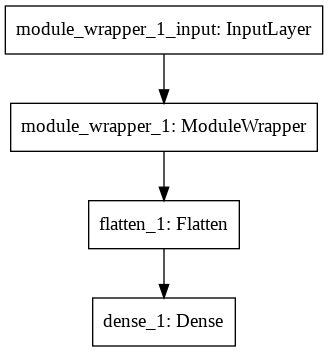

In [16]:
vggface_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

model_emotion = tf.keras.Sequential([vggface_model, 
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dense(2, activation='linear')])
model_emotion.build(input_shape=(None, 224, 224, 3))

model_emotion.summary()
plot_model(model_emotion)

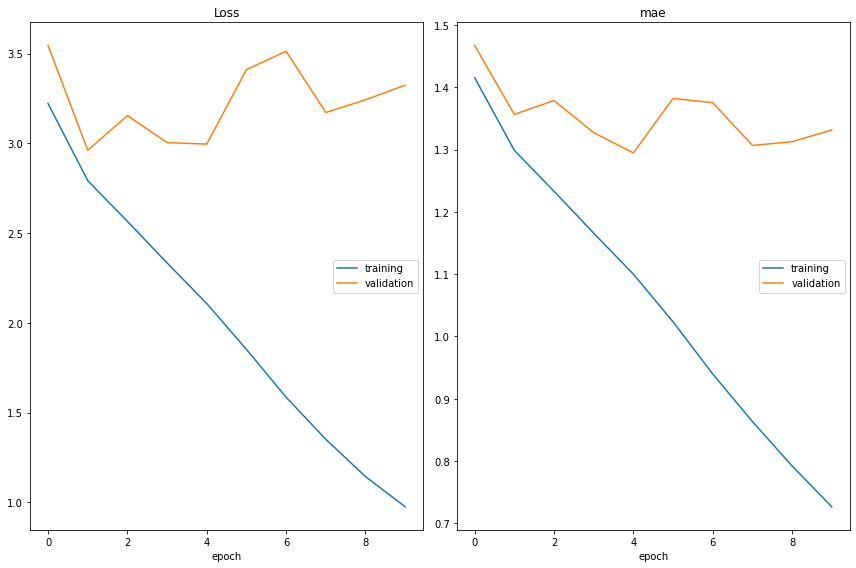

Loss
	training         	 (min:    0.975, max:    3.222, cur:    0.975)
	validation       	 (min:    2.962, max:    3.546, cur:    3.324)
mae
	training         	 (min:    0.727, max:    1.416, cur:    0.727)
	validation       	 (min:    1.295, max:    1.467, cur:    1.331)

Epoch 00010: val_mae did not improve from 1.29472
77/77 [==============================] - 70s 913ms/step - loss: 2.9962 - mae: 1.2947


[2.996192693710327, 1.294718861579895]

In [19]:
cpt_path = str(PATH_MYDRIVE / 'model_emotion/checkpoint_best_VA_weights.hdf5')

#LearningRateScheduler
def scheduler(epoch, lr):
   if epoch < 5:
     return lr
   else:
     return lr * tf.math.exp(-0.1)

my_callbacks = [PlotLossesCallback(),
                tf.keras.callbacks.ModelCheckpoint(cpt_path,
                                                   monitor='val_mae',
                                                   verbose=1,
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   save_freq='epoch',
                                                   mode='min'),
                tf.keras.callbacks.LearningRateScheduler(scheduler)]  

model_emotion.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss='mse',
              metrics='mae')

EPOCHS = 10
history = model_emotion.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=my_callbacks)

model_emotion.load_weights(PATH_MYDRIVE / 'model_emotion/checkpoint_best_VA_weights.hdf5')
model_emotion.evaluate(val_data_gen)

# Инференс модели Valence / Arousal
Алгоритм отнесения изображения к той или иной эмоции предусматривает принятие решения по критерию НАИМЕНЬШЕГО расстояния от точки предикта до любой из центральных точек в 9-ти классах эмоций. Ближайший центр той или иной эмоции является определяющим для изображений.

In [20]:
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга. 
    содержит отрицательные значения и некорректно отображается matplotlib

    return: корректно отображаемая картинка типа np.uint8(!!). 

    ! работайте с копией картинки (image = np.copy(vggface_image)) !
    """
    image = np.copy(vggface_image)
    image[..., 0] += 91.4953
    image[..., 1] += 103.8827
    image[..., 2] += 131.0912
    image = image[..., ::-1]
    image = image.astype(np.uint8)
    
    return image

In [21]:
def get_emotion(v, a, scale=0.4):
    for emotion in VA_mapping.keys():
        if (VA_mapping[emotion][0] - scale <= v <= VA_mapping[emotion][0] + scale) and (VA_mapping[emotion][1] - scale <= a <= VA_mapping[emotion][1] + scale):
            return emotion
            break
    else:
        return "Unknown"

In [22]:
def show_faces(images, labels_v=None, labels_a=None, predicted_v=None, predicted_a=None):
    plt.figure(figsize=(10,10))
    f_labels = {"Emotion": [predicted_v, predicted_a, labels_v, labels_a]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predict_v, predict_a, label_v, label_a) in f_labels.items():
            if predict_v is None:
                continue
                
            else:
                real_emotion = get_emotion(label_v[i], label_a[i])
                dot = np.array((predict_v[i], predict_a[i])).ravel()
                distances = np.linalg.norm(np.array(list(VA_mapping.values())) - dot, axis=1)
                min_index = np.argmin(distances)              
                predicted_emotion = list(VA_mapping.keys())[min_index]
                real_str += f"{real_emotion}, "
                pred_str += f"{predicted_emotion}, "
                if real_emotion != predicted_emotion:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')

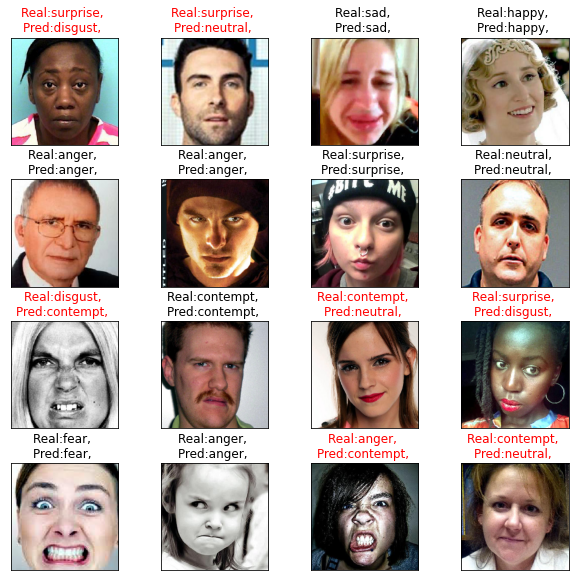

In [34]:
sample_validation_images, sample_validation_labels = next(val_data_gen)
predicted = model_emotion.predict(sample_validation_images)

sample_validation_labels = np.hsplit(sample_validation_labels, 2)
predicted = np.hsplit(predicted, 2)

show_faces(images=sample_validation_images, 
           labels_v=sample_validation_labels[0],
           labels_a=sample_validation_labels[1],
           predicted_v=predicted[0],
           predicted_a=predicted[1])

Проведем анализ полученных предсказаний на датасете df_train

Верно распознанных изображений 46.79 % ( из 49013 ).


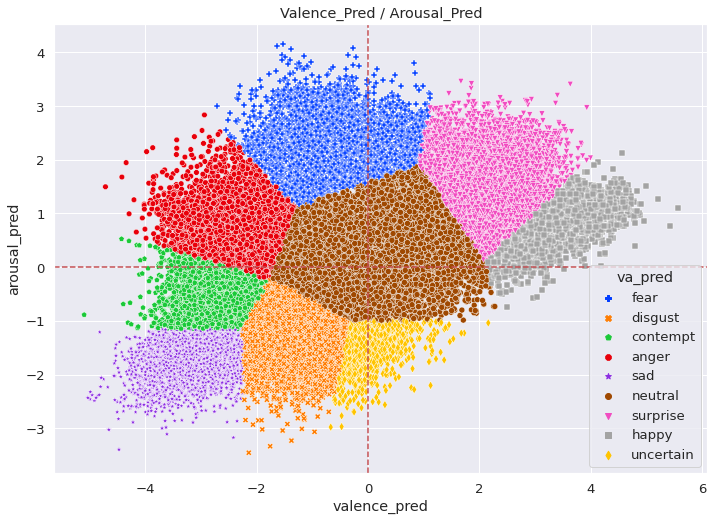

In [40]:
#row[4] - emotion, row[9] - image_path
count = 0
va_pred = []
valence_pred = []
arousal_pred = []

for row in df_train.itertuples():
  img = image.load_img(PATH_TRAIN / row[9], target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = utils.preprocess_input(x, version=2)
  predicts = model_emotion.predict(x)
  dot = np.array((predicts[0][0],predicts[0][1]))
  distances = np.linalg.norm(np.array(list(VA_mapping.values())) - dot, axis=1)
  min_index = np.argmin(distances)
  va_pred.append(list(VA_mapping.keys())[min_index])
  valence_pred.append(predicts[0][0])
  arousal_pred.append(predicts[0][1])
  if list(VA_mapping.keys())[min_index] == row[4]:
    count += 1

df_train['va_pred'] = va_pred
df_train['valence_pred'] = valence_pred
df_train['arousal_pred'] = arousal_pred

df_train.to_csv(PATH_MYDRIVE / 'df_train.csv', sep=',', index_label='index')
print('Верно распознанных изображений', round(count / df_train.shape[0] * 100,2),'% ( из',df_train.shape[0],').')

sns.set(rc={'figure.figsize': (11.7, 8.27)}, font_scale=1.2, style='darkgrid')

markers = {'anger': '8', 
           'contempt': 'p', 
           'disgust': 'X', 
           'fear': 'P', 
           'happy':'s', 
           'neutral':'o', 
           'sad':'*', 
           'surprise':'v', 
           'uncertain':'d'}

sns.scatterplot(x='valence_pred', y='arousal_pred', data=df_train,
                hue='va_pred', palette='bright', style='va_pred', markers=markers)
plt.title('Valence_Pred / Arousal_Pred')
plt.axvline(x=0, color="r", linestyle="--")
plt.axhline(y=0, color="r", linestyle="--")
plt.show()

А теперь рассмотрим распределение предсказанных значений по датасету df_test. Выгрузим полученные результаты в kaggle.

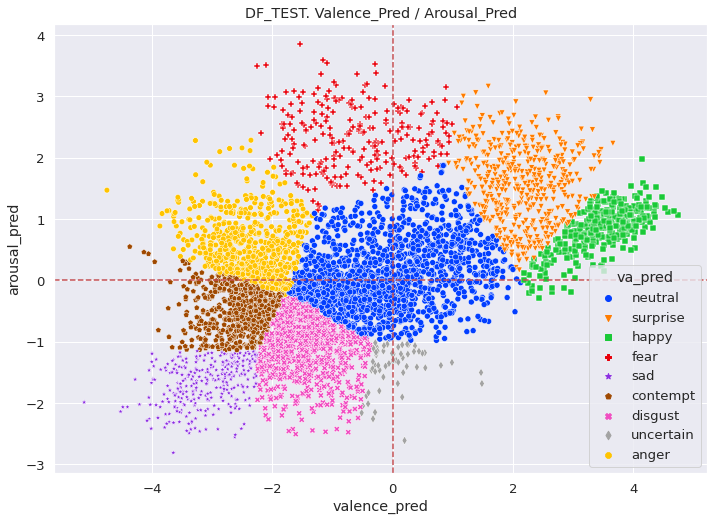

In [41]:
va_pred = []
valence_pred = []
arousal_pred = []

for row in df_test.itertuples():
  img = image.load_img(PATH_TEST / row[5], target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = utils.preprocess_input(x, version=2)
  predicts = model_emotion.predict(x)
  dot = np.array((predicts[0][0],predicts[0][1]))
  distances = np.linalg.norm(np.array(list(VA_mapping.values())) - dot, axis=1)
  min_index = np.argmin(distances)
  va_pred.append(list(VA_mapping.keys())[min_index])
  valence_pred.append(predicts[0][0])
  arousal_pred.append(predicts[0][1])

df_test['va_pred'] = va_pred
df_test['valence_pred'] = valence_pred
df_test['arousal_pred'] = arousal_pred

df_test.to_csv(PATH_MYDRIVE / 'df_test.csv', sep=',', index_label='index')

sns.set(rc={'figure.figsize': (11.7, 8.27)}, font_scale=1.2, style='darkgrid')

markers = {'anger': '8', 
           'contempt': 'p', 
           'disgust': 'X', 
           'fear': 'P', 
           'happy':'s', 
           'neutral':'o', 
           'sad':'*', 
           'surprise':'v', 
           'uncertain':'d'}

sns.scatterplot(x='valence_pred', y='arousal_pred', data=df_test,
                hue='va_pred', palette='bright', style='va_pred', markers=markers)
plt.title('DF_TEST. Valence_Pred / Arousal_Pred')
plt.axvline(x=0, color="r", linestyle="--")
plt.axhline(y=0, color="r", linestyle="--")
plt.show()

In [42]:
sample_submission = df_test[['image_path','va_pred']].copy()
sample_submission['emotion'] = sample_submission['va_pred']
sample_submission.reset_index(inplace=True)
sample_submission = sample_submission.drop(['va_pred','index'], axis=1)
sample_submission.to_csv(PATH_MYDRIVE / 'model_emotion/sample_submission_va.csv', index=False)

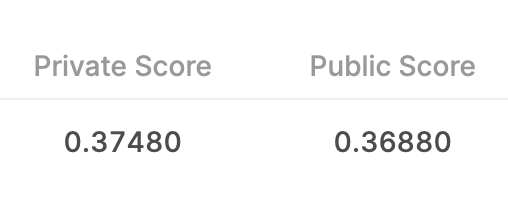

Определим наиболее типичные несовпадения реальных эмоций с предсказанными по алгоритму Valence / Arousal

In [44]:
i = 0
df_confusion = df_train[['emotion','va_pred']].copy()
df_confusion['count'] = 1
df_confusion = df_confusion.groupby(['emotion','va_pred']).sum()
df_confusion['emotion'] = df_confusion.index.get_level_values(0)
df_confusion['va_pred'] = df_confusion.index.get_level_values(1)
df_confusion.sort_values('count', ascending=False, inplace=True)
for row in df_confusion.itertuples():
  if row[0][0] != row[0][1] and i < 10:
    i += 1
    print('Real:',row[0][0],', Pred:',row[0][1],', Error:',row[1])

Real: surprise , Pred: neutral , Error: 2222
Real: uncertain , Pred: disgust , Error: 2093
Real: uncertain , Pred: neutral , Error: 2010
Real: sad , Pred: contempt , Error: 1567
Real: anger , Pred: contempt , Error: 1550
Real: happy , Pred: neutral , Error: 1426
Real: neutral , Pred: disgust , Error: 1354
Real: contempt , Pred: neutral , Error: 1229
Real: sad , Pred: disgust , Error: 1100
Real: fear , Pred: neutral , Error: 936


# Вывод.
Обученная ML-модель VGGFace по искусственно сгенерированным данным (Valence / Arousal) в  47 % случаев относит изображение к "верной" эмоции и позволяет получить достаточный для "зачета" scor на Kaggle.

---